In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
import itertools
import joblib
from matplotlib import pyplot as plot
import os

In [2]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [3]:
#loading file
amino_acid_df = pd.read_excel("data/AminoAcid.xlsx", header=None)
amino_acid_df.columns = ['protein', 'sequence']

c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda')

In [5]:
amino_acid_df.head()

,protein,sequence
0,1EP9_1,VQLKGRDLLTLKNFTGEEIKYMLWLSADLKFRIKQKGEYLPLLQGK...
1,1BH9_1,LFSKELRCMMYGFGDDQNPYTESVDILEDLVIEFITEMTHKAMSI
2,1G96_1,VGGPMDASVEEEGVRRALDFAVGEYNKASNDMYHSRALQVVRARKQ...
3,1CYV_1,MIPGGLSEAKPATPEIQEIVDKVKPQLEEKTNETYGKLEAVQYKTQ...
4,1KE5_1,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIR


In [6]:
#spliting the sequences in letters
amino_acid_df['sequence'] = amino_acid_df['sequence'].apply(lambda seq: list(seq))

In [7]:
amino_acid_df.head()

,protein,sequence
0,1EP9_1,"[V, Q, L, K, G, R, D, L, L, T, L, K, N, F, T, ..."
1,1BH9_1,"[L, F, S, K, E, L, R, C, M, M, Y, G, F, G, D, ..."
2,1G96_1,"[V, G, G, P, M, D, A, S, V, E, E, E, G, V, R, ..."
3,1CYV_1,"[M, I, P, G, G, L, S, E, A, K, P, A, T, P, E, ..."
4,1KE5_1,"[M, E, N, F, Q, K, V, E, K, I, G, E, G, T, Y, ..."


One-hot encoding of the amino-acid sequence.

In [8]:
unique_amino_acid = list(set([item for sublist in amino_acid_df['sequence'] for item in sublist]))
unique_amino_acid.sort()

In [9]:
max_lenght_amino_acid = len(max(amino_acid_df['sequence'], key=len))

In [10]:
# Function to one-hot encode a sequence of amino acid.
# The output is a matrix of max_lenght_amino_acid (1965) x unique_amino_acid (21). Sequence shorter than max_lenght_amino_acid are filled with 0. 
def one_hot_encode(seq):
    matrix = np.zeros((max_lenght_amino_acid, len(unique_amino_acid)))
    for idx, elem in enumerate(seq):
        matrix[idx][unique_amino_acid.index(elem)] = 1
    return matrix.astype(np.float32)


In [11]:
amino_acid_df['seq_one_hot'] = amino_acid_df['sequence'].apply(lambda seq: one_hot_encode(seq))


Autoencoder

In [12]:
class AE_Conv(nn.Module):
    def __init__(self, in_channels, num_layers, latent_dim):
        super().__init__()
        # self.layers = [input_shape, *layers]
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        # Encoder
        encoder_modules = nn.ModuleList()
        for i in range(num_layers):
            out_channels = latent_dim * (2 ** (num_layers - i))
            encoder_modules.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1))
            encoder_modules.append(nn.ReLU())
            # encoder_modules.append(nn.MaxPool1d(kernel_size=2, stride=2))
            in_channels = out_channels
        self.encoder = nn.Sequential(*encoder_modules)

        # Decoder
        decoder_modules = nn.ModuleList()
        for i in range(num_layers-1, -1, -1):
            if i == 0:
                out_channels = self.in_channels
            else:
                out_channels = latent_dim * (2 ** (num_layers - i +1))
            decoder_modules.append(nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1))
            decoder_modules.append(nn.ReLU())
            # decoder_modules.append(nn.Upsample(scale_factor=2, mode='linear', align_corners=True))
            in_channels = out_channels
        self.decoder = nn.Sequential(*decoder_modules)
        


    def forward(self, input):
        # print(input.shape)
        # input = input.reshape(1,-1)
        input = self.encoder(input)
        input = self.decoder(input)
        return input
ae = AE_Conv(max_lenght_amino_acid, 2, 100).to(gpu)
ae

AE_Conv(
  (encoder): Sequential(
    (0): Conv1d(1965, 400, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(400, 200, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(200, 400, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(400, 1965, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
)

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid acitvation
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [14]:
def train(autoencoder:AE_Conv, data:pd.DataFrame, optimizer:optim, epochs:int = 10, batch_size:int = 64, loss_fn =DiceLoss()):
    train_losses = []
    test_losses = []
    train_idx, val_idx = train_test_split(list(range(len(data))), test_size=0.15)
    train_data = Subset(data, train_idx)
    test_data = Subset(data, val_idx)
    train_dataloader = DataLoader(train_data,batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data,batch_size=batch_size, shuffle=True)
    for i in range(epochs):
        # print('epoch {}'.format(i))
        epoch_loss = []
        test_loss = []

        # Training
        for _, batch in tqdm(enumerate(train_dataloader), total=np.ceil(len(train_data)/batch_size)):
            autoencoder.zero_grad()
            batch = batch.to(gpu)
            output = autoencoder(batch)
            loss_train = loss_fn(output, batch)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_loss.append(loss_train.item())

        # Test Set
        for _, batch in enumerate(test_dataloader):
            autoencoder.zero_grad()
            batch = batch.to(gpu)
            output = autoencoder(batch)
            loss_test = loss_fn(output, batch)
            test_loss.append(loss_test.item())

        train_losses.append(np.average(epoch_loss))
        test_losses.append(np.average(test_loss))
    return train_losses, test_losses
    
        


In [15]:
batch_size=512
for layers, latent_dim, (opt,name), (loss,loss_name) in itertools.product([3], [50,100,200,300],
                                            [(optim.Adagrad, 'Adagrad'), (optim.Adam, 'Adam')],
                                            [(nn.MSELoss, "MSE")]):
    gc.collect()
    print(layers, latent_dim, name, loss_name)
    ae = AE_Conv(max_lenght_amino_acid, layers, latent_dim).to(gpu)
    optimizer = opt(ae.parameters(), lr=0.01)
    loss_fn = loss()
    epochs = 20

    train_loss, test_loss = train(ae, amino_acid_df['seq_one_hot'], optimizer,epochs=epochs, batch_size=batch_size, loss_fn=loss_fn)
    joblib.dump({'autoencoder': ae,
                 "optimizer": optimizer,
                 "train_loss": train_loss,
                 "test_loss": test_loss,
                 "layers":layers,
                 "loss_fn": loss
                 }, "models/{}_{}_{}_{}_{}_test.joblib".format(layers,latent_dim,name,loss_name, epochs))

3 50 Adagrad MSE


100%|██████████| 73/73.0 [00:13<00:00,  5.27it/s]
100%|██████████| 73/73.0 [00:08<00:00,  9.03it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.26it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.41it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.31it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.38it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.61it/s]
100%|██████████| 73/73.0 [00:08<00:00,  9.07it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.38it/s]
100%|██████████| 73/73.0 [00:08<00:00,  9.00it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.50it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.41it/s]
100%|██████████| 73/73.0 [00:09<00:00,  8.08it/s]
100%|██████████| 73/73.0 [00:09<00:00,  7.90it/s]
100%|██████████| 73/73.0 [00:10<00:00,  7.06it/s]
100%|██████████| 73/73.0 [00:11<00:00,  6.57it/s]
100%|██████████| 73/73.0 [00:16<00:00,  4.54it/s]
100%|██████████| 73/73.0 [00:09<00:00,  8.02it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.71it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.45it/s]


3 50 Adam MSE


100%|██████████| 73/73.0 [00:08<00:00,  8.70it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.65it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.37it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.96it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.23it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.98it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.19it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.28it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.18it/s]
100%|██████████| 73/73.0 [00:08<00:00,  9.06it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.18it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.24it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.37it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.98it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.27it/s]
100%|██████████| 73/73.0 [00:07<00:00,  9.21it/s]
100%|██████████| 73/73.0 [00:08<00:00,  9.04it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.29it/s]
100%|██████████| 73/73.0 [00:08<00:00,  8.39it/s]
100%|██████████| 73/73.0 [00:09<00:00,  8.09it/s]


3 100 Adagrad MSE


100%|██████████| 73/73.0 [00:12<00:00,  6.01it/s]
100%|██████████| 73/73.0 [00:11<00:00,  6.09it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.06it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.95it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.01it/s]
100%|██████████| 73/73.0 [00:11<00:00,  6.11it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.99it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.03it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.96it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.06it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.98it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.06it/s]
100%|██████████| 73/73.0 [00:11<00:00,  6.10it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.02it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.03it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.91it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.93it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.03it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.99it/s]
100%|██████████| 73/73.0 [00:11<00:00,  6.10it/s]


3 100 Adam MSE


100%|██████████| 73/73.0 [00:13<00:00,  5.43it/s]
100%|██████████| 73/73.0 [00:13<00:00,  5.44it/s]
100%|██████████| 73/73.0 [00:13<00:00,  5.25it/s]
100%|██████████| 73/73.0 [00:13<00:00,  5.29it/s]
100%|██████████| 73/73.0 [00:13<00:00,  5.34it/s]
100%|██████████| 73/73.0 [00:14<00:00,  5.09it/s]
100%|██████████| 73/73.0 [00:14<00:00,  4.95it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.69it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.68it/s]
100%|██████████| 73/73.0 [00:13<00:00,  5.55it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.31it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.82it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.93it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.90it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.96it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.76it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.04it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.98it/s]
100%|██████████| 73/73.0 [00:12<00:00,  6.04it/s]
100%|██████████| 73/73.0 [00:12<00:00,  5.85it/s]


3 200 Adagrad MSE


100%|██████████| 73/73.0 [00:24<00:00,  2.98it/s]
100%|██████████| 73/73.0 [00:23<00:00,  3.12it/s]
100%|██████████| 73/73.0 [00:23<00:00,  3.17it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.34it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.31it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.41it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.33it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.32it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.30it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.26it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.39it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.44it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.45it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.40it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.25it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.24it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.26it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.21it/s]
100%|██████████| 73/73.0 [00:23<00:00,  3.12it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.21it/s]


3 200 Adam MSE


100%|██████████| 73/73.0 [00:22<00:00,  3.28it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.26it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.37it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.39it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.35it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.46it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.47it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.40it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.44it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.42it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.36it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.39it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.32it/s]
100%|██████████| 73/73.0 [00:22<00:00,  3.31it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.33it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.39it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.34it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.36it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.39it/s]
100%|██████████| 73/73.0 [00:21<00:00,  3.40it/s]


3 300 Adagrad MSE


100%|██████████| 73/73.0 [00:32<00:00,  2.26it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.30it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.34it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.35it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.35it/s]
100%|██████████| 73/73.0 [00:30<00:00,  2.36it/s]
100%|██████████| 73/73.0 [00:30<00:00,  2.36it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.34it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.30it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.29it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.29it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.23it/s]
100%|██████████| 73/73.0 [00:31<00:00,  2.31it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.25it/s]
100%|██████████| 73/73.0 [00:33<00:00,  2.20it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.27it/s]
100%|██████████| 73/73.0 [00:33<00:00,  2.17it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.22it/s]
100%|██████████| 73/73.0 [00:33<00:00,  2.19it/s]
100%|██████████| 73/73.0 [00:33<00:00,  2.19it/s]


3 300 Adam MSE


100%|██████████| 73/73.0 [00:33<00:00,  2.16it/s]
100%|██████████| 73/73.0 [00:34<00:00,  2.13it/s]
100%|██████████| 73/73.0 [00:34<00:00,  2.09it/s]
100%|██████████| 73/73.0 [00:34<00:00,  2.13it/s]
100%|██████████| 73/73.0 [00:34<00:00,  2.10it/s]
100%|██████████| 73/73.0 [00:34<00:00,  2.09it/s]
100%|██████████| 73/73.0 [00:33<00:00,  2.16it/s]
100%|██████████| 73/73.0 [00:33<00:00,  2.17it/s]
100%|██████████| 73/73.0 [00:35<00:00,  2.08it/s]
100%|██████████| 73/73.0 [00:35<00:00,  2.07it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.23it/s]
100%|██████████| 73/73.0 [00:33<00:00,  2.21it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.22it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.25it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.24it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.25it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.24it/s]
100%|██████████| 73/73.0 [00:33<00:00,  2.18it/s]
100%|██████████| 73/73.0 [00:32<00:00,  2.23it/s]
100%|██████████| 73/73.0 [00:34<00:00,  2.10it/s]


In [16]:
class AE_lin(nn.Module):
    def __init__(self, input_shape, layers):
        super().__init__()
        self.layers = [input_shape, *layers]
        self.input_shape = input_shape
        # Encoder
        encoder_modules = nn.ModuleList()
        for idx in range(len(self.layers)-1):
            # print('encoder: ',self.layers[idx], self.layers[idx+1])

            encoder_modules.append(
                nn.Sequential(
                    nn.Linear(self.layers[idx], self.layers[idx+1]),
                    nn.ReLU(),
                )
            )
        self.encoder = nn.Sequential(*encoder_modules)

        # Decoder
        decoder_modules = nn.ModuleList()
        for idx in range(len(self.layers)-1):
            # print('decoder: ',self.layers[-idx - 1], self.layers[-idx-2])
            decoder_modules.append(
                nn.Sequential(
                    nn.Linear(self.layers[-idx-1], self.layers[-idx-2]),
                    nn.ReLU(),
                )
            )
        self.decoder = nn.Sequential(*decoder_modules)


    def forward(self, input):
        # input = input.reshape(1,-1)
        input = self.encoder(input)
        input = self.decoder(input)
        return input


In [17]:
import os

models = {}

for f in os.listdir('models'):
    path = os.path.join('models', f)
    models[f] = joblib.load(path)


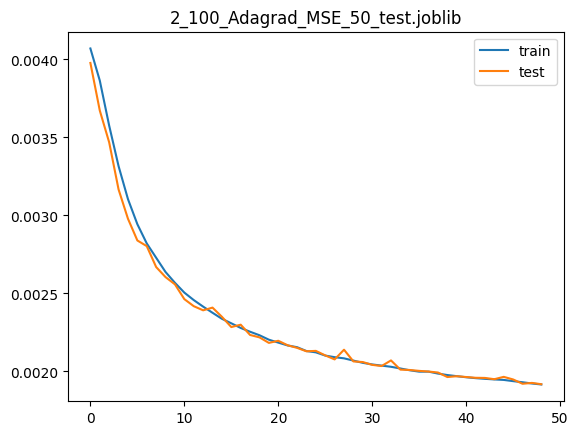

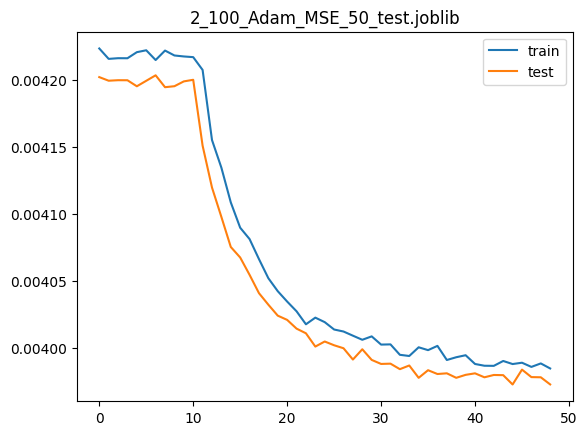

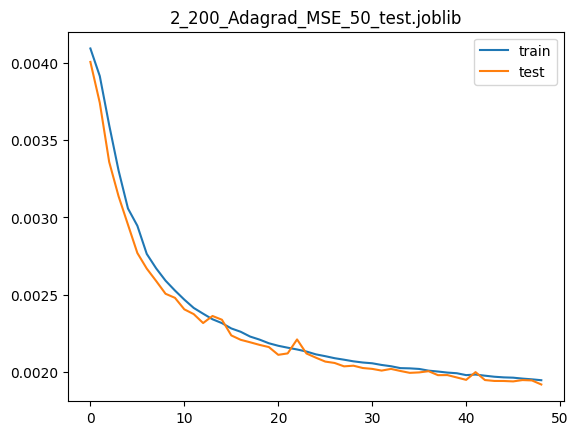

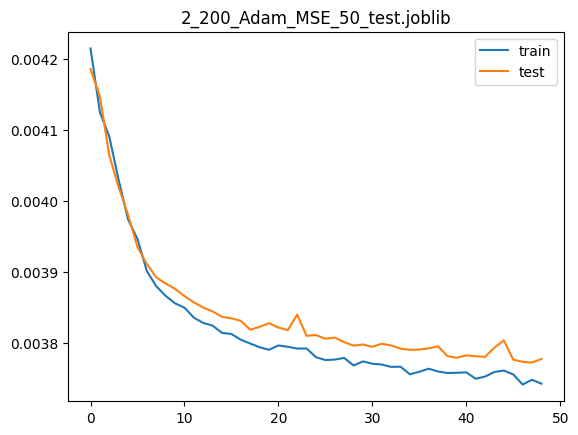

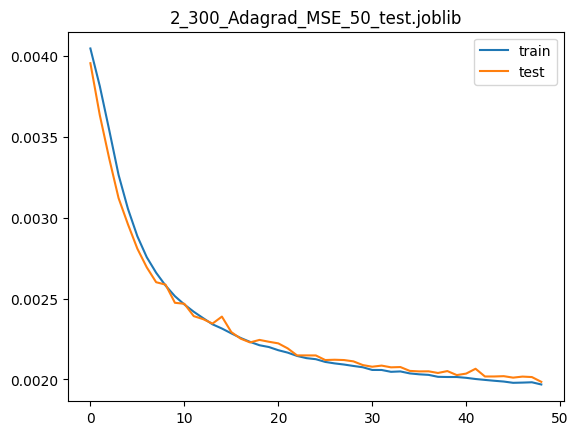

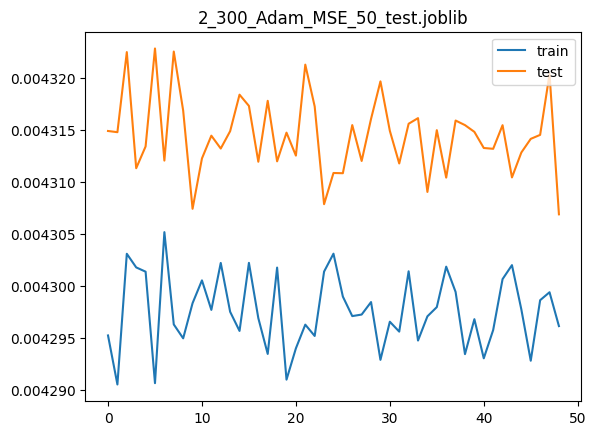

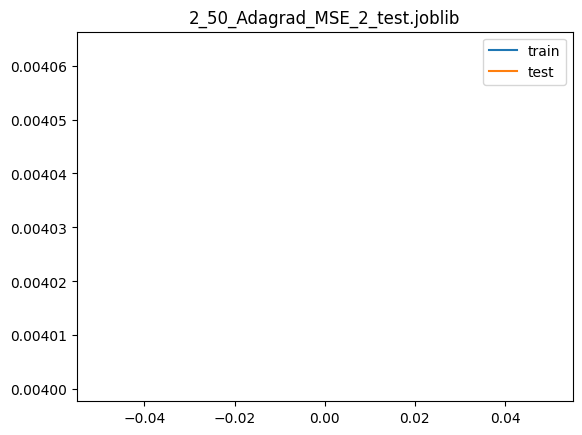

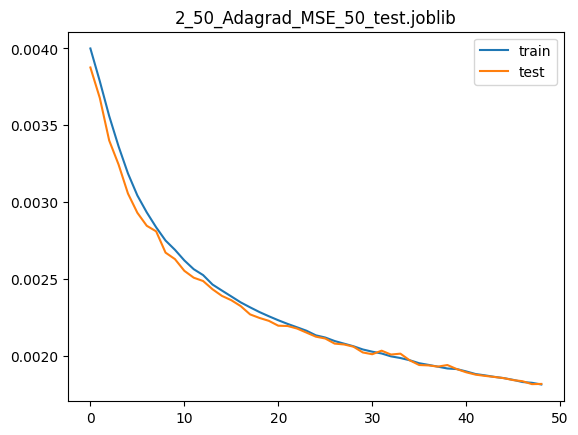

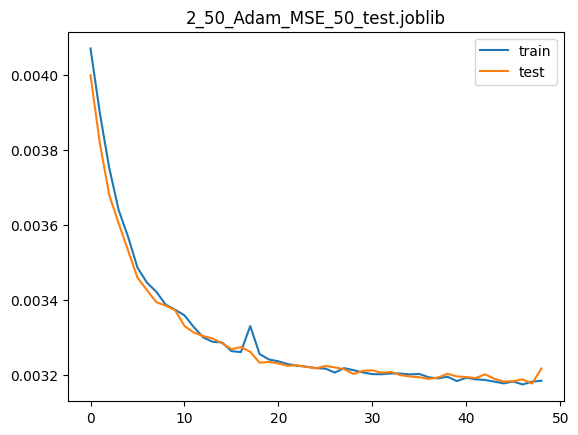

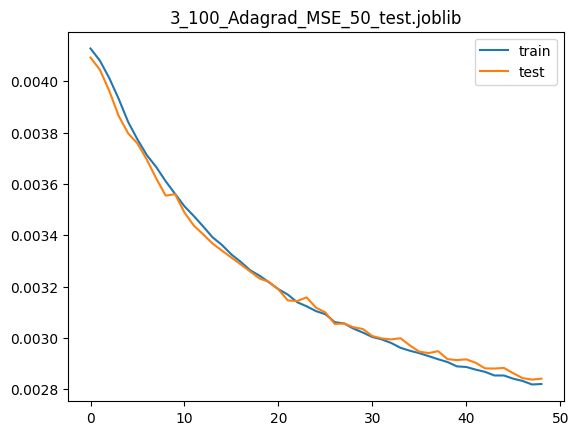

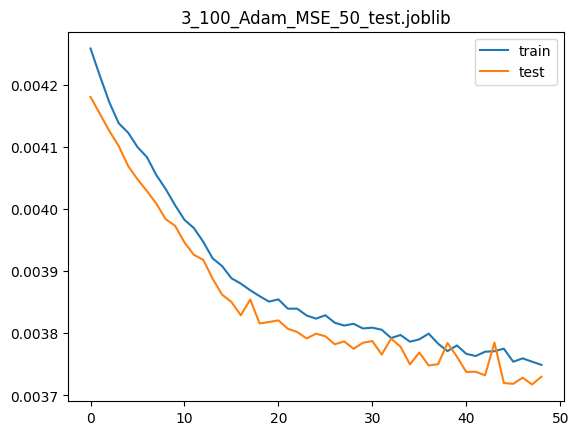

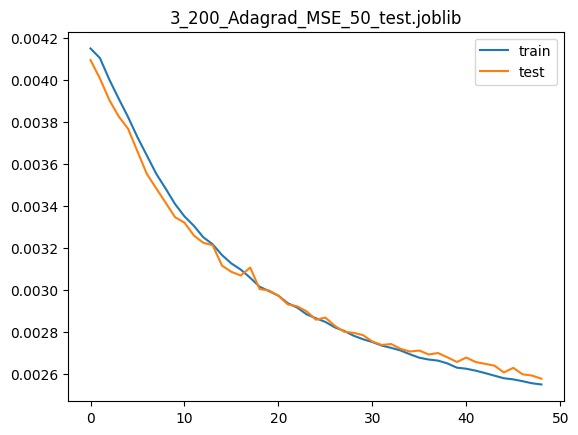

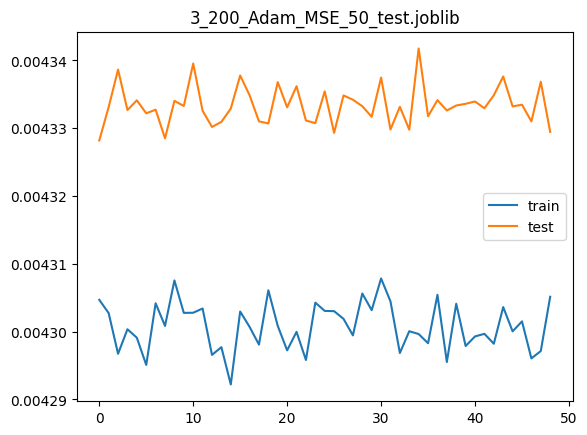

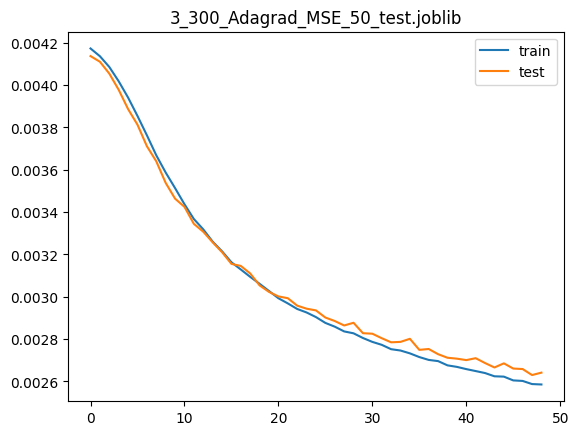

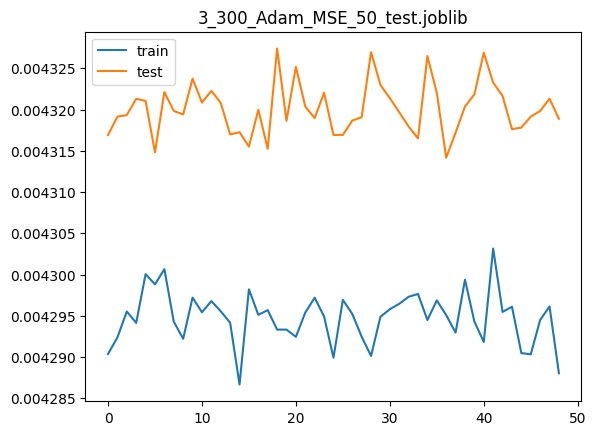

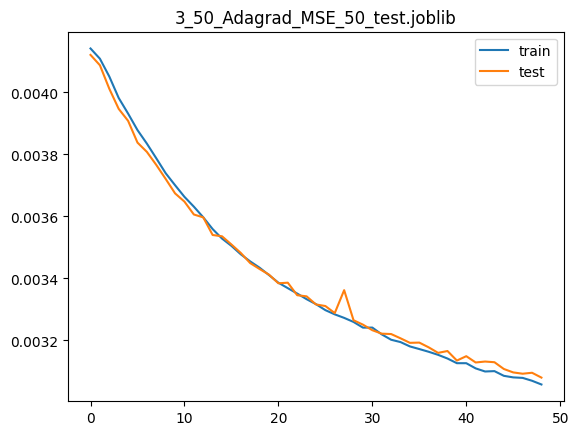

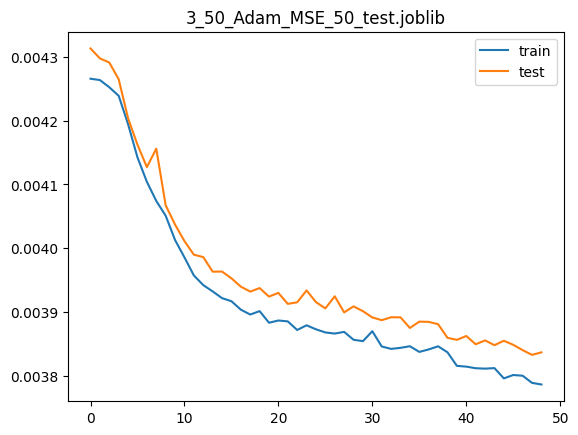

In [22]:
for model, val in models.items():
    if 'test' in model:
        # print(val)
        plot.plot(range(len(val['train_loss'])-1), val['train_loss'][1:], label='train')
        plot.plot(range(len(val['test_loss'])-1), val['test_loss'][1:], label='test')
        plot.legend()
        plot.title(model)
        plot.show()

In [19]:
amino_acid_df['seq_one_hot'][:100]

0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                            ...                        
95    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
96    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
97    [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
98    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
99    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: seq_one_hot, Length: 100, dtype: object

In [20]:
gc.collect()
a = {}
for model, val in models.items():
    avg = []
    if model.split('_')[0] in ['2','3', '4'] and 'MSE' in model:
        dataloader = DataLoader(amino_acid_df['seq_one_hot'],batch_size=3000, shuffle=True)
        print(model)
        for _, batch in tqdm(enumerate(dataloader)):
            batch = batch.to(gpu)
            m = val['autoencoder']
            ouput = m(batch)
            q = np.flatnonzero(ouput.detach().cpu().numpy())
            avg.append(len(q)/len(batch))
        a[model] = np.mean(avg)
        print(a[model])
    # if stop:
    #     break

2_100_Adagrad_MSE_50.joblib


0it [00:02, ?it/s]


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 495180000 bytes.

In [ ]:
for w in a:
    if a[w]<800 and a[w]> 100:
        print(w, a[w])

2_100_Adagrad_MSE_50.joblib 187.0804340998735
2_200_Adagrad_MSE_50.joblib 125.3605803081045
2_300_Adagrad_MSE_50.joblib 147.61998544317927
2_50_Adagrad_MSE_50.joblib 237.94571265907567
2_Adagrad_MSE.joblib 282.51631237627447
2_Adagrad_MSE_30.joblib 281.9136930267172
2_Adagrad_MSE_60.joblib 245.35923259656175
2_Adam_MSE_30.joblib 164.64889253553622
3_100_Adagrad_MSE_50.joblib 151.80265923941354
3_200_Adagrad_MSE_50.joblib 170.38392478975962
3_50_Adagrad_MSE_50.joblib 245.98099127781498
3_Adagrad_MSE.joblib 515.6752203616878
3_Adagrad_MSE_30.joblib 315.5476526456798
3_Adagrad_MSE_60.joblib 293.6164776214929
3_Adam_MSE_60.joblib 528.1681870060281
